# Model training

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import List, Dict, Optional, Tuple, Union
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader
import random
import math

In [51]:

def set_seed(seed: int = 0) -> None:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(0)

In [52]:
def plot_grid(images):
    fig, axs = plt.subplots(images.shape[0], figsize=(10, 10))
    for i in range(images.shape[0]):
            axs[i].imshow(images[i].numpy().transpose((1,2,0)), cmap='gray')
            axs[i].axis('off')


This UNet architecture was taken from [UNet for DDPM](https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/unet.py), where I just modified changing the Swish function for nn.SiLU, dropout rate for the residual block to 0.5, changing num_groups to 4 and the channel of the initial feature map to be just 16. This results in a 10M parameter model compared to 41M parameters from the unmodified UNet.

In [53]:
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = nn.SiLU()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings
        # [same as those from the transformer](../../transformers/positional_encoding.html)
        #
        # \begin{align}
        # PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
        # PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
        # \end{align}
        #
        # where $d$ is `half_dim`
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb


class ResidualBlock(nn.Module):
    """
    ### Residual block

    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int,
                 n_groups: int = 2, dropout: float = 0.5):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        * `dropout` is the dropout rate
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_act = nn.SiLU()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

class AttentionBlock(nn.Module):
    """
    ### Attention block

    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 4):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=2)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
    ### Up block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block

    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 1, n_channels: int = 16,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[bool]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = nn.SiLU()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We define the Diffusion Model here with cosine noise scheduler. Since we are interested in image reconstruction, a function is made to take in the noised image and the time step that it was noised to. We reverse this process by applying backward diffusion the same number of times.

In [55]:
class DiffusionModel(nn.Module):
  def __init__(self,model,steps,s_val,image_shape,channels):
    super(DiffusionModel, self).__init__()
    self.model = model
    self.steps = steps
    self.s_val = s_val
    self.image_shape = image_shape
    self.channels = channels
    self.beta = self.beta_schedule(steps,s_val)
    self.alphas = 1-self.beta
    self.alphas_cumprod = np.cumprod(self.alphas, axis = -1)

  def beta_schedule(self, steps, s_val):
    def f(t):
      return np.cos((t/steps+s_val)/(1+s_val)*0.5*torch.pi)**2
    x = np.linspace(0,steps,steps+1)
    alphas_cumproduct = f(x)/f(np.array([0]))
    beta_ = 1 - alphas_cumproduct[1:]/alphas_cumproduct[:-1]
    beta_ = np.clip(beta_,0.0001,0.999)
    return beta_


  def forward_diffusion(self, image,step):
    try:
      step = step.to('cpu')
    except:
      pass
    sqrt_alphacumprod = torch.Tensor(np.sqrt(self.alphas_cumprod[step])).view(-1,1,1,1).to(device)
    sqrt_oneminus_alphacumprod = torch.Tensor(np.sqrt(1-self.alphas_cumprod[step])).view(-1,1,1,1).to(device)
    epsilon = torch.randn_like(image).to(device)
    noised_image = sqrt_alphacumprod*image.to(device) + sqrt_oneminus_alphacumprod*epsilon
    return noised_image, epsilon

  def backward_diffusion(self, noised_img, step):
    noise = self.model(noised_img, step)
    return noise
  #it will take in one noised image at a time
  def reconstruct_imgs(self, n_img, time):
    self.model.eval()
    with torch.no_grad():
      denoised_img = n_img.to(device)
      for step in tqdm(range(time)):
        step = time - step - 1
        step = torch.full((1,), step).to(device)
        predicted_noise = self.backward_diffusion(denoised_img,step)
        alpha_t = self.alphas[step]
        alpha_cumprod_t = self.alphas_cumprod[step]

        denoised_img = (1/np.sqrt(alpha_t))*(denoised_img - ((1-alpha_t)/np.sqrt(1 - alpha_cumprod_t))* predicted_noise)
    self.model.train()
    return denoised_img
  #this function generated one sample at a time
  def generate_samples(self, number_samples):
    self.model.eval()
    with torch.no_grad():
      samples = torch.randn(number_samples, self.channels, self.image_shape, self.image_shape, device = device)

      for step in tqdm(range(self.steps)):
        step = self.steps - step -1
        step = torch.full((number_samples,), step)
        predicted_noise = self.backward_diffusion(samples, step.to(device))
        alpha_t = self.alphas[step]

        #alpha_t = torch.from_numpy(alpha_t)
        #alpha_t = alpha_t.to(device)[0]
        alpha_cumprod_t = self.alphas_cumprod[step]
        #alpha_cumprod_t = torch.Tensor([self.alphas_cumprod[step]]).to(device)[0][0]
        samples = (1 / np.sqrt(alpha_t)) * (samples - (1 - alpha_t) / np.sqrt((1 - alpha_cumprod_t)) * predicted_noise)
    self.model.train()
    return samples



In [56]:
model = DiffusionModel(UNet().to(device),1000,0.008,32,1)

In [57]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

# define the dataloader
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [58]:
images, _ = next(iter(train_loader))
images = images[0:5].to(device)
noised_images, eps = model.forward_diffusion(images, [100,200,300,500,999])

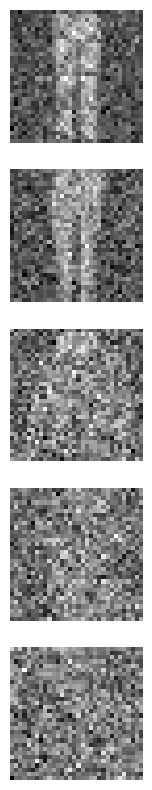

In [59]:
plot_grid(noised_images.to('cpu'))

In [60]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0) -> List:
  train_loss = []
  set_seed()
  model.train()
  for batch_idx,(images,targets) in enumerate(tqdm(train_loader)):

    # Zero the parameter gradients
    optimizer.zero_grad()
    images = images.to(device)
    # Forward + backward + optimize
    randtime = torch.randint(0,model.steps,(images.shape[0],),device=device)
    noised_imgs, eps = model.forward_diffusion(images,randtime)
    #print(noised_images.float())
    output = model.backward_diffusion(noised_imgs.float(), randtime)
    loss = loss_fn(output, eps)
    loss.backward()
    optimizer.step()


    train_loss.append(loss.item())
  return train_loss



100%|██████████| 938/938 [01:11<00:00, 13.14it/s]


0.2676681711523136


100%|██████████| 938/938 [01:11<00:00, 13.21it/s]


0.10120673144438755


100%|██████████| 938/938 [01:10<00:00, 13.24it/s]


0.07211783311085533


100%|██████████| 938/938 [01:10<00:00, 13.23it/s]


0.05847557398802372


100%|██████████| 938/938 [01:11<00:00, 13.19it/s]


0.05028975934290619


100%|██████████| 938/938 [01:11<00:00, 13.18it/s]


0.04470351195808794


100%|██████████| 938/938 [01:10<00:00, 13.21it/s]


0.04122486510383549


100%|██████████| 938/938 [01:10<00:00, 13.23it/s]


0.03870131038645628


100%|██████████| 938/938 [01:10<00:00, 13.22it/s]


0.03636373810446275


100%|██████████| 938/938 [01:10<00:00, 13.26it/s]


0.034662105091440396


100%|██████████| 1000/1000 [00:19<00:00, 52.35it/s]


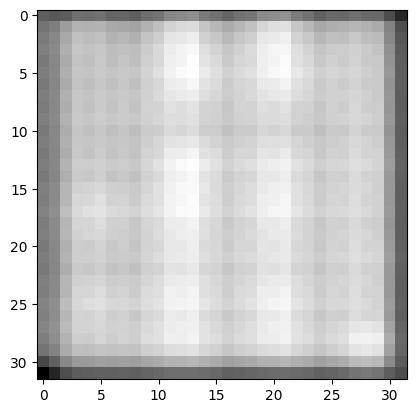

100%|██████████| 938/938 [01:10<00:00, 13.29it/s]


0.03327323450967034


100%|██████████| 938/938 [01:11<00:00, 13.15it/s]


0.031943402899457005


100%|██████████| 938/938 [01:11<00:00, 13.14it/s]


0.030854444369983507


100%|██████████| 938/938 [01:11<00:00, 13.11it/s]


0.029913493533378473


100%|██████████| 938/938 [01:10<00:00, 13.21it/s]


0.02898520734935586


100%|██████████| 938/938 [01:10<00:00, 13.24it/s]


0.028213015611547588


100%|██████████| 938/938 [01:11<00:00, 13.16it/s]


0.02740469984988223


100%|██████████| 938/938 [01:11<00:00, 13.12it/s]


0.026686650937172905


100%|██████████| 938/938 [01:11<00:00, 13.19it/s]


0.026105824187755394


100%|██████████| 938/938 [01:11<00:00, 13.21it/s]


0.02554596949722181


100%|██████████| 1000/1000 [00:19<00:00, 51.86it/s]


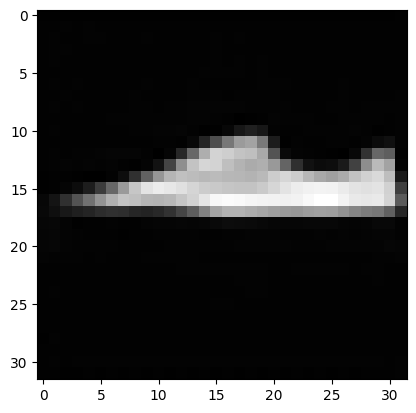

100%|██████████| 938/938 [01:11<00:00, 13.20it/s]


0.024969180339951314


100%|██████████| 938/938 [01:10<00:00, 13.26it/s]


0.024305990769037368


100%|██████████| 938/938 [01:10<00:00, 13.24it/s]


0.02382736104423367


100%|██████████| 938/938 [01:10<00:00, 13.25it/s]


0.02351704459768464


100%|██████████| 938/938 [01:10<00:00, 13.26it/s]


0.02300414554516612


100%|██████████| 938/938 [01:10<00:00, 13.23it/s]


0.022481846380859677


100%|██████████| 938/938 [01:11<00:00, 13.19it/s]


0.022124278433581213


100%|██████████| 938/938 [01:11<00:00, 13.15it/s]


0.021790290386406088


100%|██████████| 938/938 [01:11<00:00, 13.08it/s]


0.02151512573443369


100%|██████████| 938/938 [01:11<00:00, 13.15it/s]


0.02117793015571736


100%|██████████| 1000/1000 [00:19<00:00, 51.64it/s]


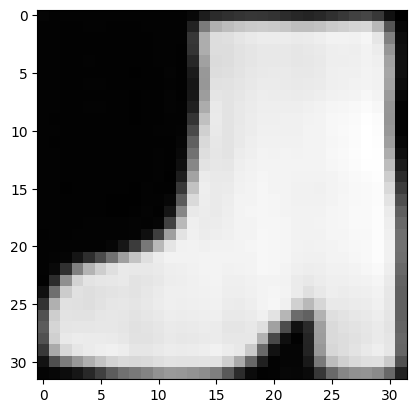

100%|██████████| 938/938 [01:11<00:00, 13.14it/s]


0.020567732780719043


100%|██████████| 938/938 [01:11<00:00, 13.19it/s]


0.020095883835869622


100%|██████████| 938/938 [01:11<00:00, 13.14it/s]


0.01990184146883105


100%|██████████| 938/938 [01:11<00:00, 13.20it/s]


0.019814224367631653


100%|██████████| 938/938 [01:10<00:00, 13.21it/s]


0.019610180698239853


100%|██████████| 938/938 [01:11<00:00, 13.20it/s]


0.01919448002775722


100%|██████████| 938/938 [01:11<00:00, 13.19it/s]


0.01882932682249592


100%|██████████| 938/938 [01:11<00:00, 13.17it/s]


0.018585714461432815


100%|██████████| 938/938 [01:11<00:00, 13.16it/s]


0.018405933620662354


100%|██████████| 938/938 [01:11<00:00, 13.18it/s]


0.01824067566873454


100%|██████████| 1000/1000 [00:19<00:00, 51.99it/s]


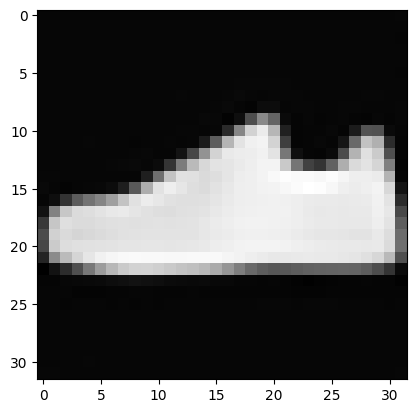

100%|██████████| 938/938 [01:11<00:00, 13.15it/s]


0.018024858232758352


100%|██████████| 938/938 [01:11<00:00, 13.10it/s]


0.017765062828875904


100%|██████████| 938/938 [01:11<00:00, 13.18it/s]


0.01748582499244733


100%|██████████| 938/938 [01:10<00:00, 13.23it/s]


0.017209794250195785


100%|██████████| 938/938 [01:11<00:00, 13.18it/s]


0.01702362643594522


100%|██████████| 938/938 [01:10<00:00, 13.22it/s]


0.01683702307846596


100%|██████████| 938/938 [01:11<00:00, 13.21it/s]


0.016630069428145378


100%|██████████| 938/938 [01:11<00:00, 13.18it/s]


0.016471620322937874


100%|██████████| 938/938 [01:11<00:00, 13.11it/s]


0.01634596252063317


100%|██████████| 938/938 [01:11<00:00, 13.12it/s]


0.016180056560812377


100%|██████████| 1000/1000 [00:19<00:00, 52.17it/s]


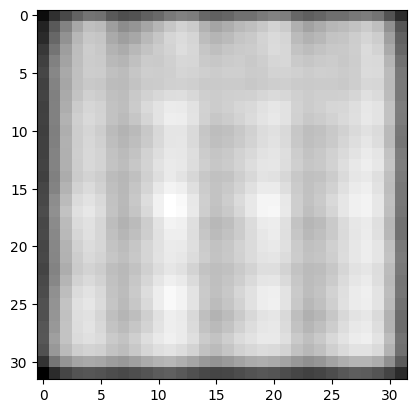

100%|██████████| 938/938 [01:11<00:00, 13.19it/s]


0.01594217468464155


100%|██████████| 938/938 [01:11<00:00, 13.18it/s]


0.015651475270288682


100%|██████████| 938/938 [01:11<00:00, 13.14it/s]


0.015409834421813678


100%|██████████| 938/938 [01:11<00:00, 13.21it/s]


0.01524307880985505


100%|██████████| 938/938 [01:10<00:00, 13.22it/s]


0.015090780886712231


100%|██████████| 938/938 [01:11<00:00, 13.18it/s]


0.01491780832324471


100%|██████████| 938/938 [01:11<00:00, 13.15it/s]


0.014816293474544944


100%|██████████| 938/938 [01:11<00:00, 13.21it/s]


0.014748732007340963


100%|██████████| 938/938 [01:10<00:00, 13.25it/s]


0.014675878942993754


100%|██████████| 938/938 [01:10<00:00, 13.25it/s]


0.014566343179397555


100%|██████████| 1000/1000 [00:19<00:00, 52.21it/s]


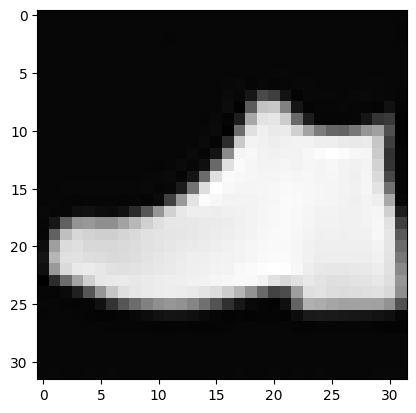

100%|██████████| 938/938 [01:10<00:00, 13.24it/s]


0.014396788359288055


100%|██████████| 938/938 [01:10<00:00, 13.21it/s]


0.014135489911476432


100%|██████████| 938/938 [01:10<00:00, 13.21it/s]


0.013820889451082296


100%|██████████| 938/938 [01:11<00:00, 13.21it/s]


0.013584569705201428


100%|██████████| 938/938 [01:11<00:00, 13.21it/s]


0.013461580771063245


100%|██████████| 938/938 [01:11<00:00, 13.18it/s]


0.013398799247471794


100%|██████████| 938/938 [01:11<00:00, 13.19it/s]


0.01341498599324161


100%|██████████| 938/938 [01:10<00:00, 13.26it/s]


0.013408162983567284


100%|██████████| 938/938 [01:10<00:00, 13.23it/s]


0.013225650140292831


100%|██████████| 938/938 [01:10<00:00, 13.21it/s]


0.01299914636903369


100%|██████████| 1000/1000 [00:19<00:00, 52.05it/s]


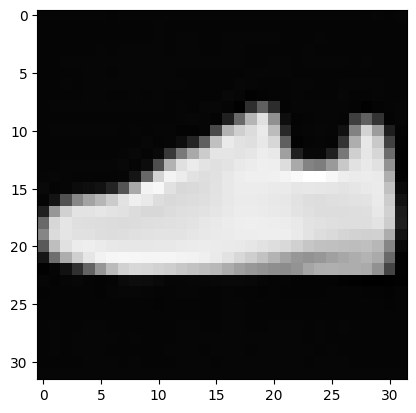

100%|██████████| 938/938 [01:11<00:00, 13.20it/s]


0.012797211377279781


100%|██████████| 938/938 [01:11<00:00, 13.15it/s]


0.01270271074235328


100%|██████████| 938/938 [01:11<00:00, 13.15it/s]


0.012610275915432682


100%|██████████| 938/938 [01:11<00:00, 13.19it/s]


0.012525488807658938


100%|██████████| 938/938 [01:11<00:00, 13.21it/s]


0.012488915621718047


100%|██████████| 938/938 [01:11<00:00, 13.20it/s]


0.012499760722181499


100%|██████████| 938/938 [01:10<00:00, 13.26it/s]


0.012403504244351724


100%|██████████| 938/938 [01:10<00:00, 13.25it/s]


0.012253897561471282


100%|██████████| 938/938 [01:11<00:00, 13.20it/s]


0.012111186441073793


100%|██████████| 938/938 [01:10<00:00, 13.21it/s]


0.011960257095461493


100%|██████████| 1000/1000 [00:19<00:00, 52.27it/s]


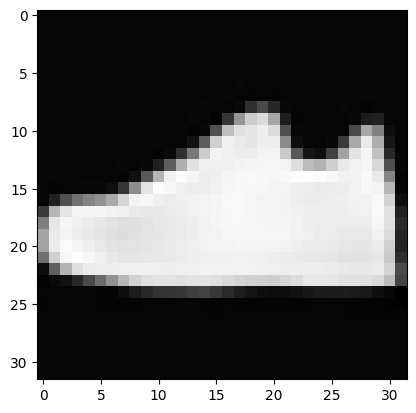

100%|██████████| 938/938 [01:11<00:00, 13.20it/s]


0.011840103092347221


100%|██████████| 938/938 [01:11<00:00, 13.16it/s]


0.011733609618547598


100%|██████████| 938/938 [01:11<00:00, 13.16it/s]


0.011665799078156255


100%|██████████| 938/938 [01:10<00:00, 13.23it/s]


0.011630790659101374


100%|██████████| 938/938 [01:11<00:00, 13.19it/s]


0.01160588511811899


100%|██████████| 938/938 [01:10<00:00, 13.22it/s]


0.011536056564540974


100%|██████████| 938/938 [01:11<00:00, 13.18it/s]


0.011421383108332087


100%|██████████| 938/938 [01:10<00:00, 13.22it/s]


0.01128165850163634


100%|██████████| 938/938 [01:11<00:00, 13.19it/s]


0.011205000828689476


100%|██████████| 938/938 [01:11<00:00, 13.15it/s]


0.011140423296674737


100%|██████████| 1000/1000 [00:19<00:00, 52.21it/s]


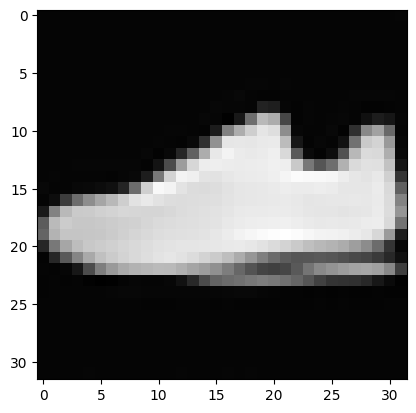

In [61]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00006)
set_seed()
max_epoch = 90
for epoch in range(1,max_epoch+1):

  loss = train(model,criterion,optimizer,train_loader,epoch)
  print(np.mean(loss))
  if epoch %10 == 0:
    generated_image = model.generate_samples(1)
    plt.clf()
    plt.imshow(generated_image[0].to('cpu').numpy().transpose((1,2,0)),cmap='gray')
    plt.show()


# Some quick tests

In [ ]:
model = DiffusionModel(UNet().to(device),1000,0.008,32,1)

In [ ]:
model.load_state_dict(torch.load('/content/DDPM_weights.pt')) #change directory to the path where DDPM_ood.pt is

## Testing on ID and OOD images

### ID

In [94]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

id_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

id_loader = DataLoader(id_dataset, batch_size=64, shuffle=True)

In [126]:
images, _ = next(iter(id_loader))
images = images[0].to(device)
noised_images, eps = model.forward_diffusion(images, [300])

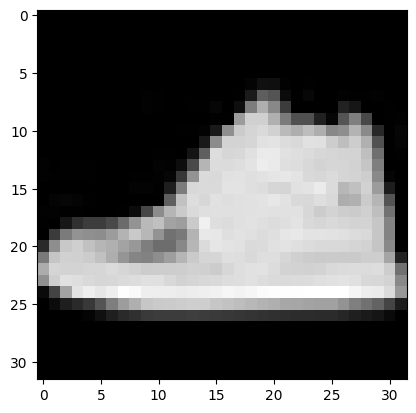

In [127]:
plt.imshow(images.to('cpu').numpy().transpose((1,2,0)),cmap='gray')

In [128]:
recon = model.reconstruct_imgs(noised_images,300)

100%|██████████| 300/300 [00:05<00:00, 51.04it/s]


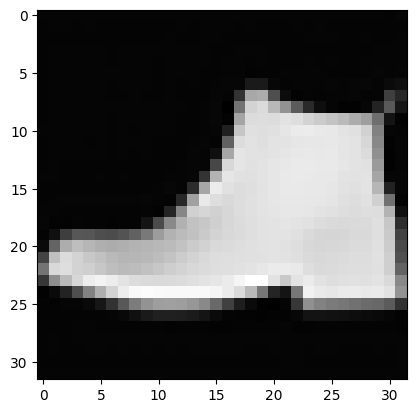

In [129]:
plt.imshow(recon[0].to('cpu').numpy().transpose((1,2,0)),cmap='gray')

### OOD

In [101]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

ood_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

ood_loader = DataLoader(ood_dataset, batch_size=64, shuffle=True)

In [106]:
images, _ = next(iter(ood_loader))
images = images[0].to(device)
noised_images, eps = model.forward_diffusion(images, [300])

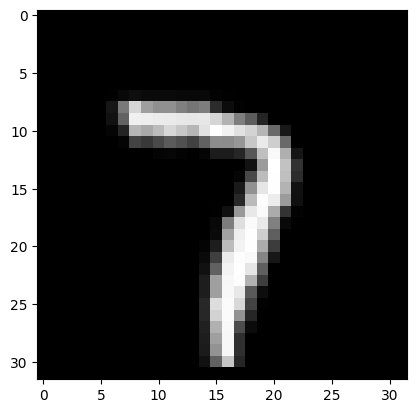

In [107]:
plt.imshow(images.to('cpu').numpy().transpose((1,2,0)),cmap='gray')

In [108]:
recon = model.reconstruct_imgs(noised_images,300)

100%|██████████| 300/300 [00:05<00:00, 52.13it/s]


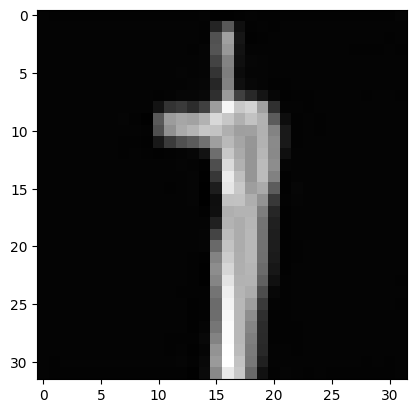

In [109]:
plt.imshow(recon[0].to('cpu').numpy().transpose((1,2,0)),cmap='gray')

### CelebA but grayscaled and resized to 32x32

We only use one CelebA image (face.jpg) in the repository.

In [110]:
import cv2
from PIL import Image

image = cv2.imread('face.jpg',0)

image = cv2.resize(image,(32,32))
PIL_image = Image.fromarray(image)
image_tr = transform(PIL_image)

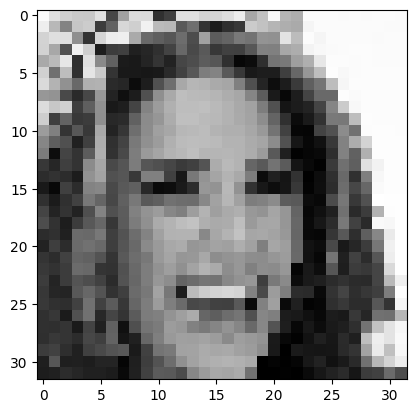

In [119]:
plt.imshow(image,cmap='gray')

Original image:

In [111]:
noised_images, eps = model.forward_diffusion(image_tr, [10])

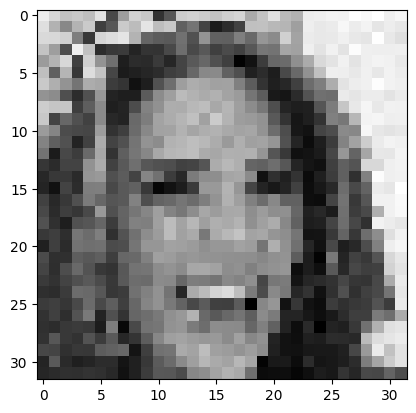

In [117]:
plt.imshow(noised_images[0].to('cpu').numpy().transpose((1,2,0)),cmap='gray')

In [113]:
recon = model.reconstruct_imgs(noised_images,10)

100%|██████████| 10/10 [00:00<00:00, 50.97it/s]


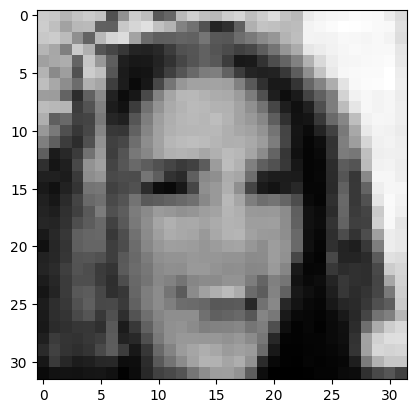

In [115]:
plt.imshow(recon[0].to('cpu').numpy().transpose((1,2,0)),cmap='gray')

Not too bad, just smoother it out but this is only with t=10. Let's try t = 100.

In [120]:
noised_images, eps = model.forward_diffusion(image_tr, [100])

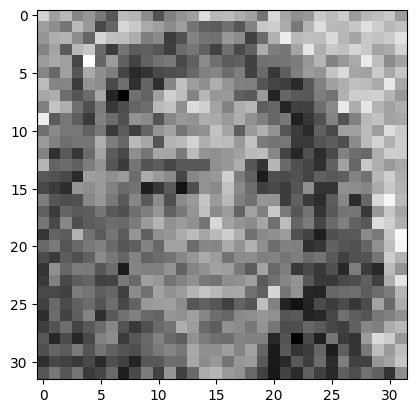

In [121]:
plt.imshow(noised_images[0].to('cpu').numpy().transpose((1,2,0)),cmap='gray')

In [122]:
recon = model.reconstruct_imgs(noised_images,100)

100%|██████████| 100/100 [00:01<00:00, 51.91it/s]


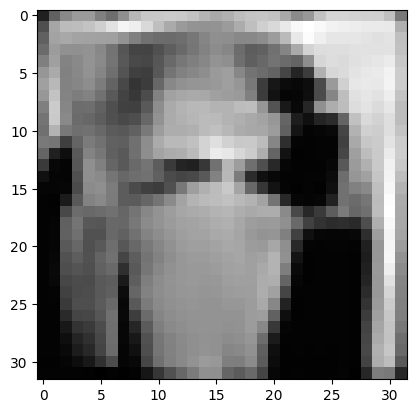

In [123]:
plt.imshow(recon[0].to('cpu').numpy().transpose((1,2,0)),cmap='gray')

Doesn't work that well anymore...